# RAPIDS & Scanpy Single-Cell RNA-seq Workflow on MnPO cells

Copyright (c) 2020, NVIDIA CORPORATION.

Licensed under the Apache License, Version 2.0 (the "License") you may not use this file except in compliance with the License. You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0 

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

This notebook demonstrates a single-cell RNA analysis workflow that begins with preprocessing a count matrix of size `(n_gene, n_cell)` and results in a visualization of the clustered cells for further analysis.

For demonstration purposes, we use a dataset of 1.3 M brain cells with Unified Virtual Memory to oversubscribe GPU memory.

## Import requirements

In [1]:
import numpy as np
import scanpy as sc
import anndata
import scipy.io
import scipy.sparse

import time
import os, wget


import cudf

from cuml.decomposition import PCA
from cuml.manifold import TSNE
from cuml.cluster import KMeans
from cuml.preprocessing import StandardScaler

import cuml
import rapids_scanpy_funcs
import utils

import warnings
warnings.filterwarnings('ignore', 'Expected ')
warnings.simplefilter('ignore')
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import rmm

from rmm.allocators.cupy import rmm_cupy_allocator
import cupy
cupy.cuda.set_allocator(rmm_cupy_allocator)
from scipy import sparse
import gc
import cupy as cp
gc.collect()
cp.get_default_memory_pool().free_all_blocks()
import calculation_tool as ct

We use the RAPIDS memory manager to enable Unified Virtual Memory management, which allows us to oversubscribe the GPU memory.

## Input data

In the cell below, we provide the path to the sparse `.h5ad` file containing the count matrix to analyze. Please see the README for instructions on how to download the dataset we use here.

To run this notebook using your own dataset, please see the README for instructions to convert your own count matrix into this format. Then, replace the path in the cell below with the path to your generated `.h5ad` file.

In [ ]:

url=r"https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE87544&format=file&file=GSE87544%5FMerged%5F17samples%5F14437cells%5Fcount%2Etxt%2Egz"
input_file="/data/mouse_hypothalamus/GSE87544_Merged_17samples_14437cells_count.txt.gz"
input_csv="/data/mouse_hypothalamus/GSE87544_Merged_17samples_14437cells_count.txt"
if not os.path.exists(input_csv):
    print('Downloading import file...')
    os.makedirs('/data/mouse_hypothalamus', exist_ok=True)
    wget.download(url,input_file)

In [5]:
adata=sc.read_text(input_csv)

In [7]:
adata=adata.transpose()

In [8]:
from scipy import sparse
sparse_X = sparse.csr_matrix(adata.X)
adata.X = sparse_X

In [ ]:
file_path="/data/mouse_hypothalamus/hypothalamus_adata.h5ad"
adata.write(file_path)

In [6]:
adata.var_names

Index(['B0CCCCGGGCTTGT_Normal', 'B0ATTGGAATGGCC_Normal',
       'B0TTCCAACCGAAG_Normal', 'B0AGCAGGCGTAAN_Normal',
       'B0TACGGTTCTACN_Normal', 'B0CGTGGTTGTTCN_Normal',
       'B0TTAGTGACCTTG_Normal', 'B0AAACAACCCCCN_Normal',
       'B0GTACAGAATGTN_Normal', 'B0CCCGGGCTTGTN_Normal',
       ...
       'B4TAGACTATCTCG_Hungry2', 'B4GAATGCAGAGTG_Hungry2',
       'B4TTAAAGGCAACG_Hungry2', 'B4CGGCTCTGCTCC_Hungry2',
       'B4TCGCAGAATAAG_Hungry2', 'B4TTGCGGACCTCG_Hungry2',
       'B4TTACGTAAGAAG_Hungry2', 'B4GTCCGGTTTTGA_Hungry2',
       'B4CATAGCCCACCC_Hungry2', 'B4CAATATGTCGGG_Hungry2'],
      dtype='object', length=14437)

preprocess_in_bulk
HTR1E is not included
HTR1E is removed from marker list
DRD1 is not included
DRD1 is removed from marker list
['CX3CR1', 'CLDN5', 'GLUL', 'NDRG2', 'PCDH15', 'PLP1', 'MBP', 'SATB2', 'SLC17A7', 'SLC17A6', 'GAD2', 'GAD1', 'SNAP25', 'HTR1A', 'HTR1B', 'HTR1D', 'HTR2A', 'HTR2B', 'HTR2C', 'HTR3A', 'HTR4', 'HTR5A', 'HTR6', 'HTR7', 'DRD2', 'DRD3', 'DRD4', 'DRD5', 'HRH1', 'HRH2', 'HRH3', 'CHRM1', 'CHRM2', 'CHRM3', 'CHRM4', 'CHRM5', 'ADRA1A', 'ADRA1B', 'ADRA2A', 'ADRA2B', 'ADRA2C', 'ADRB1', 'ADRB2', 'AGRP']
perform regression
perform scale
float32
Total Preprocessing time: 5.1883275508880615
shape of adata: (14384, 19472)
shape of adata: (14384, 19472)
perform PCA
10
t-sne
UMAP
[2025-04-11 15:09:25.383] [CUML] [info] build_algo set to brute_force_knn because random_state is given
UMAP louvain


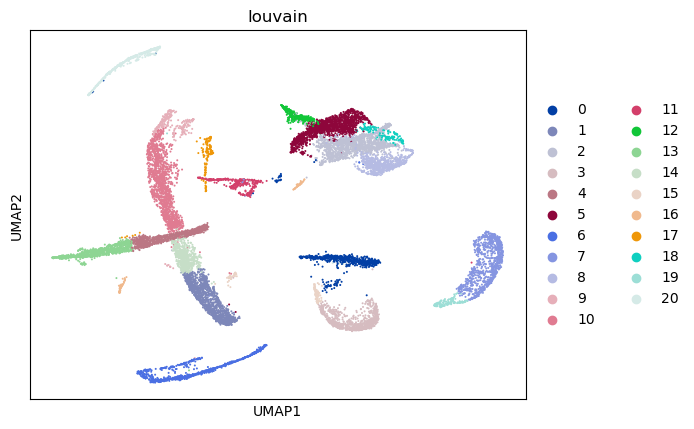

UMAP leiden


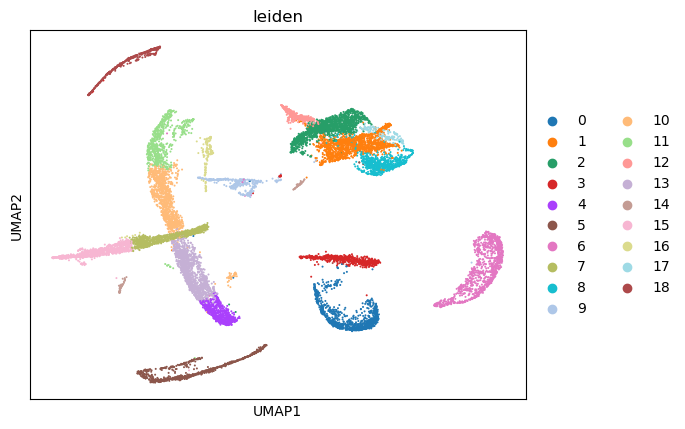

calc drug response
clz selective cells
# of clz selective cells: is_clz_selective
False    14087
True       297
Name: count, dtype: int64


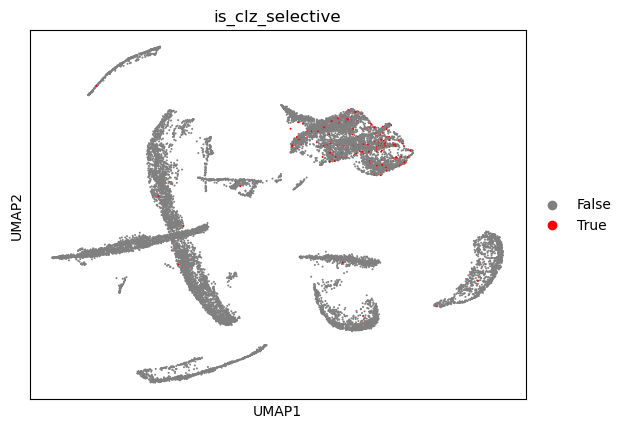

In [2]:
import calculation_tool as ct
file_path="/data/mouse_hypothalamus/hypothalamus_adata.h5ad"
add_markers=["AGRP"]
adata,GPCR_df=ct.preprocess_adata_in_bulk(file_path,label=None,add_markers=add_markers)
GPCR_df.to_csv("/data/mouse_hypothalamus/hypothalamus_data_GPCR_df.csv")

Drug concentration: 0.001
clz selective cells
# of clz selective cells: is_clz_selective
False    14350
True        34
Name: count, dtype: int64


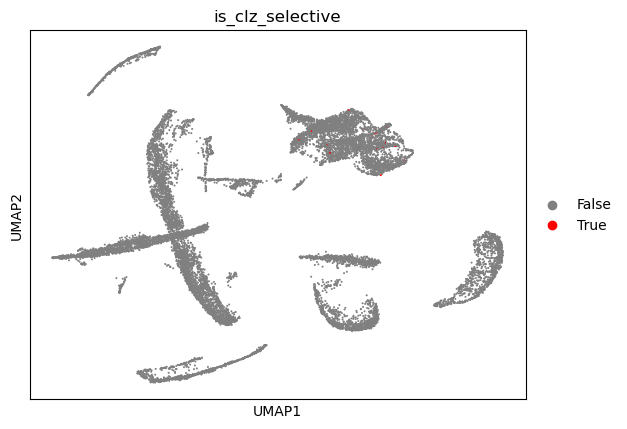

Drug concentration: 0.01
clz selective cells
# of clz selective cells: is_clz_selective
False    14350
True        34
Name: count, dtype: int64


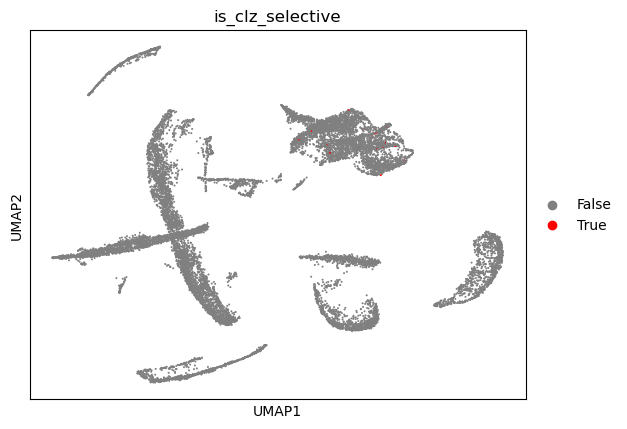

Drug concentration: 0.1
clz selective cells
# of clz selective cells: is_clz_selective
False    14350
True        34
Name: count, dtype: int64


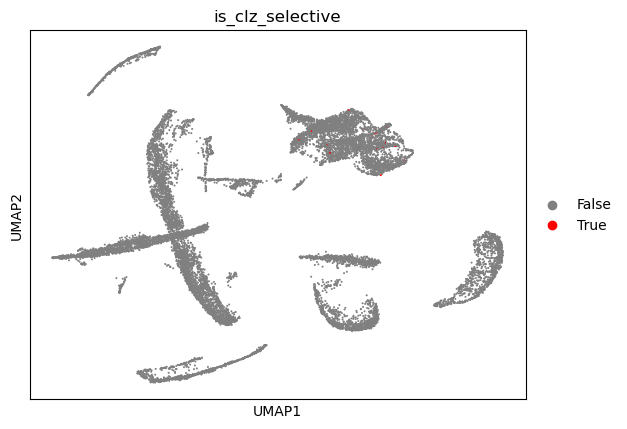

Drug concentration: 1
clz selective cells
# of clz selective cells: is_clz_selective
False    14350
True        34
Name: count, dtype: int64


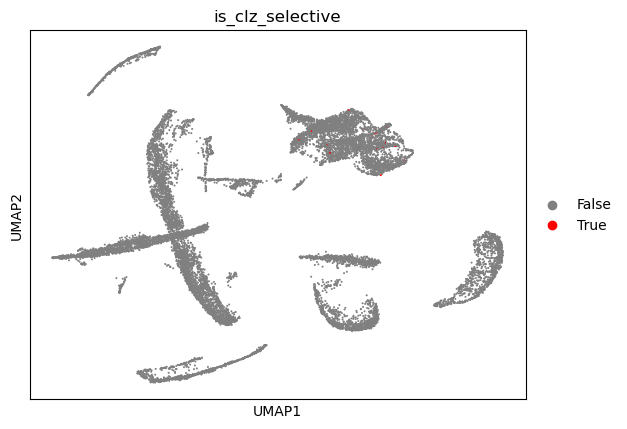

Drug concentration: 1.5848931924611136
clz selective cells
# of clz selective cells: is_clz_selective
False    14350
True        34
Name: count, dtype: int64


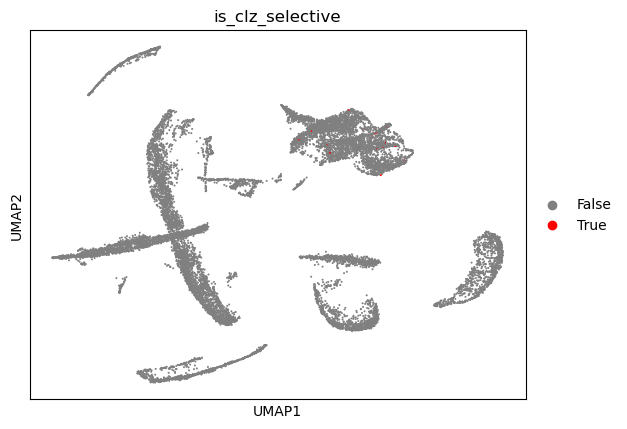

Drug concentration: 2.2387211385683394
clz selective cells
# of clz selective cells: is_clz_selective
False    14350
True        34
Name: count, dtype: int64


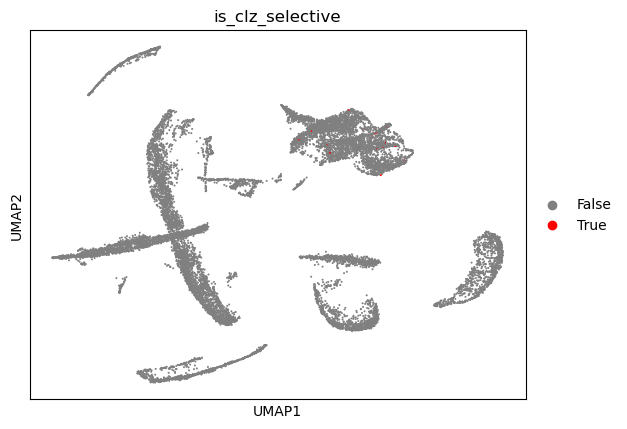

Drug concentration: 3.1622776601683795
clz selective cells
# of clz selective cells: is_clz_selective
False    14342
True        42
Name: count, dtype: int64


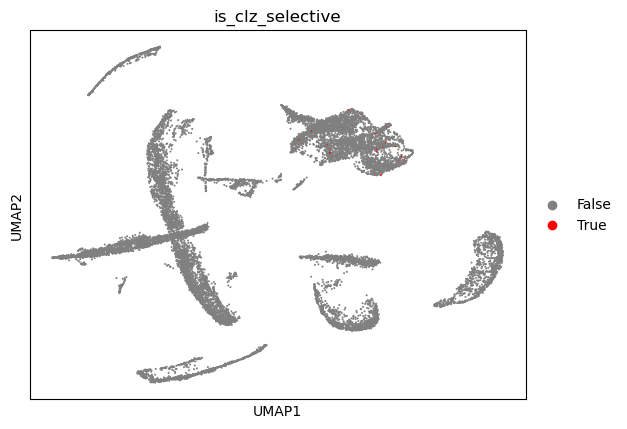

Drug concentration: 5.623413251903491
clz selective cells
# of clz selective cells: is_clz_selective
False    14314
True        70
Name: count, dtype: int64


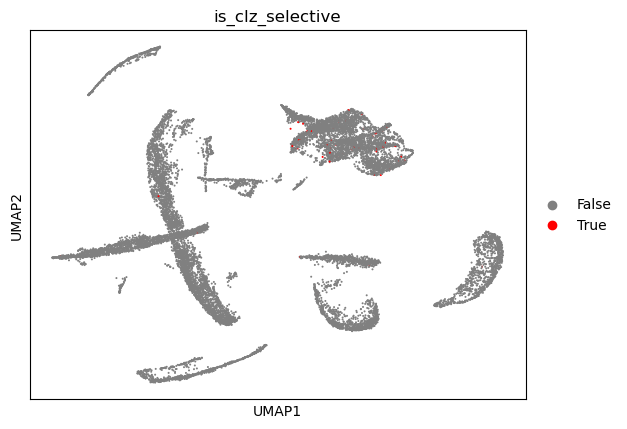

Drug concentration: 10
clz selective cells
# of clz selective cells: is_clz_selective
False    14307
True        77
Name: count, dtype: int64


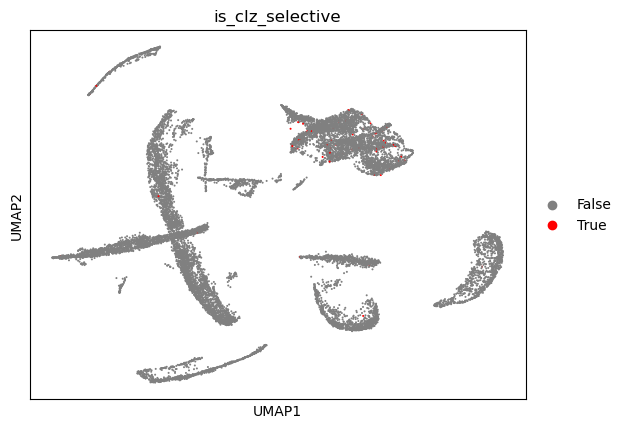

Drug concentration: 31.622776601683793
clz selective cells
# of clz selective cells: is_clz_selective
False    14293
True        91
Name: count, dtype: int64


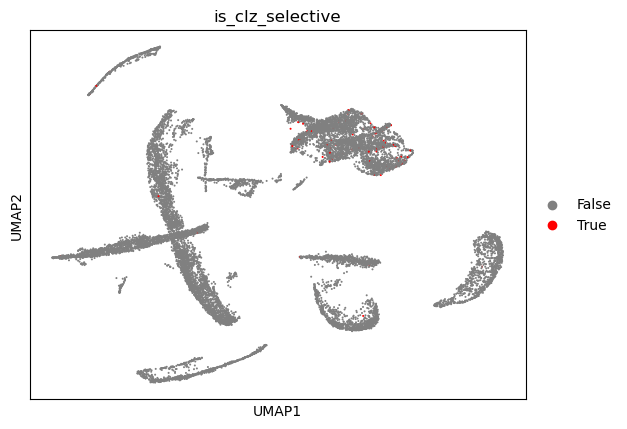

Drug concentration: 100
clz selective cells
# of clz selective cells: is_clz_selective
False    14100
True       284
Name: count, dtype: int64


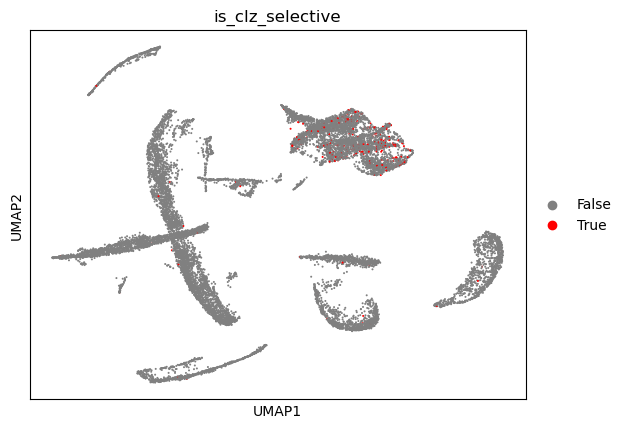

Drug concentration: 316.22776601683796
clz selective cells
# of clz selective cells: is_clz_selective
False    14092
True       292
Name: count, dtype: int64


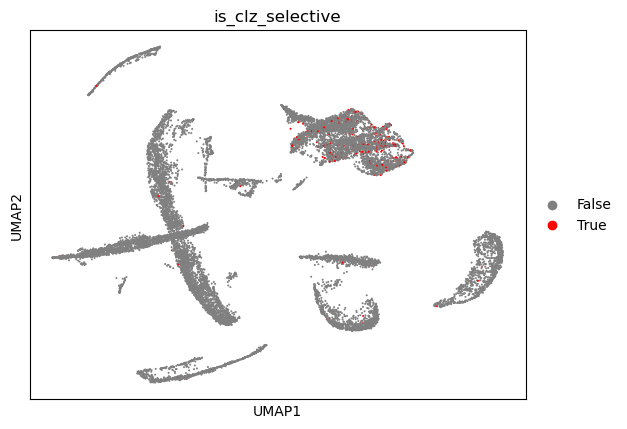

Drug concentration: 1000
clz selective cells
# of clz selective cells: is_clz_selective
False    14104
True       280
Name: count, dtype: int64


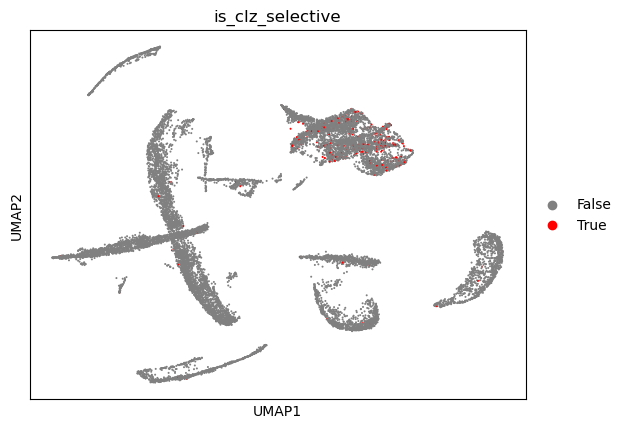

Drug concentration: 10000
clz selective cells
# of clz selective cells: is_clz_selective
False    14305
True        79
Name: count, dtype: int64


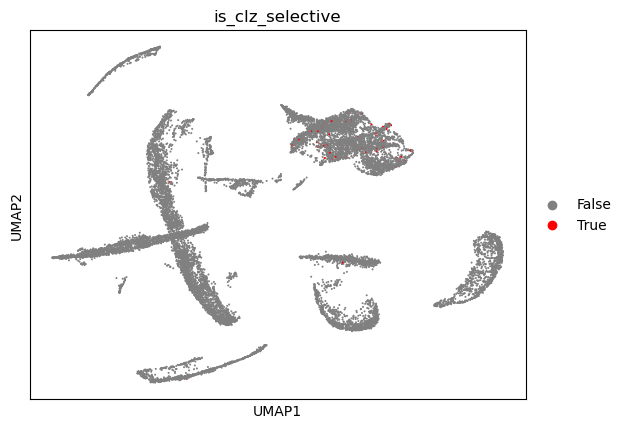

Drug concentration: 100000
clz selective cells
# of clz selective cells: is_clz_selective
False    14322
True        62
Name: count, dtype: int64


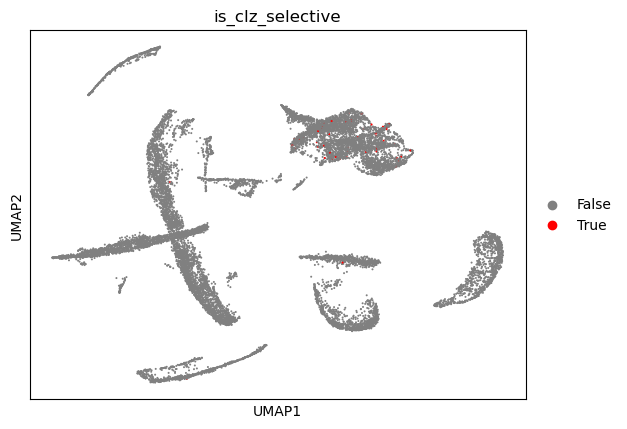

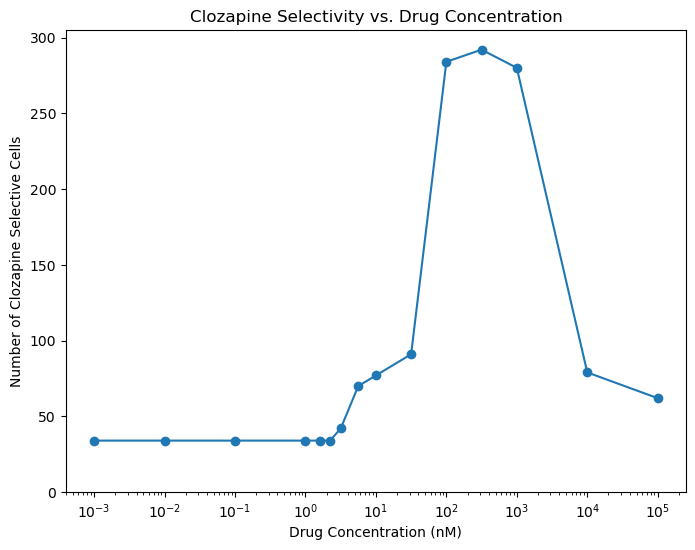

In [3]:
D_R_mtx,GPCR_type_df,drug_list,GPCR_list=ct.load_parameters()
params=ct.set_parameters_for_preprocess(GPCR_list)
import calculation_tool as ct
ct.drug_titeration(adata, GPCR_df, GPCR_type_df, drug_list, D_R_mtx)

clz selective cells
# of clz selective cells: is_clz_selective
False    14104
True       280
Name: count, dtype: int64


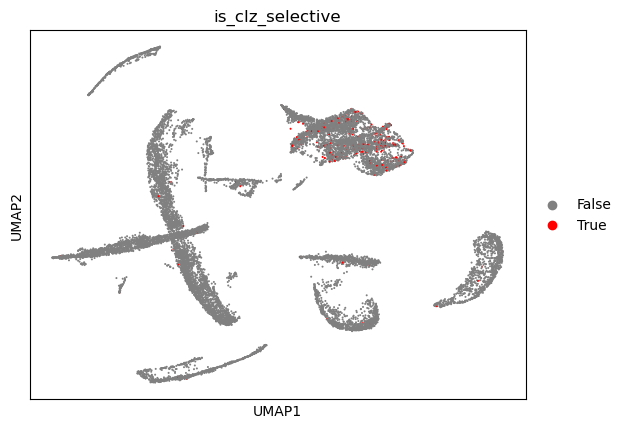

In [4]:
drug_conc=10**3
adata=ct.calc_drug_response(adata,GPCR_df,GPCR_type_df,drug_list,D_R_mtx,drug_conc)
selectivity_threshold=1.5
adata,num_clz_selective=ct.calc_clz_selective_cell(adata,drug_list,selectivity_threshold)

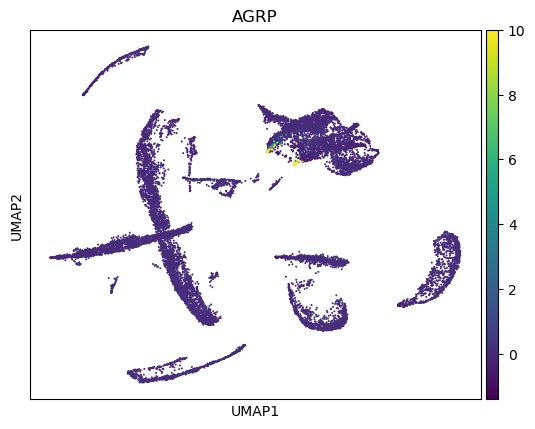

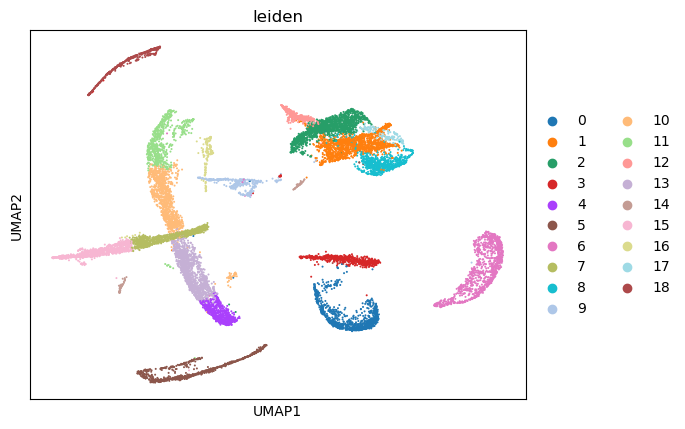

In [15]:
sc.pl.umap(adata, color=["AGRP"])
sc.pl.umap(adata, color=["leiden"])

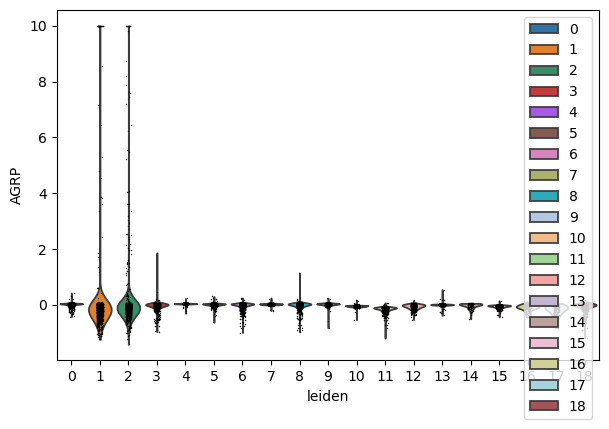

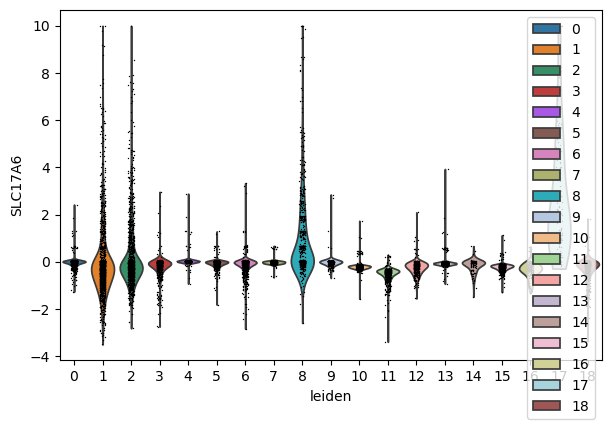

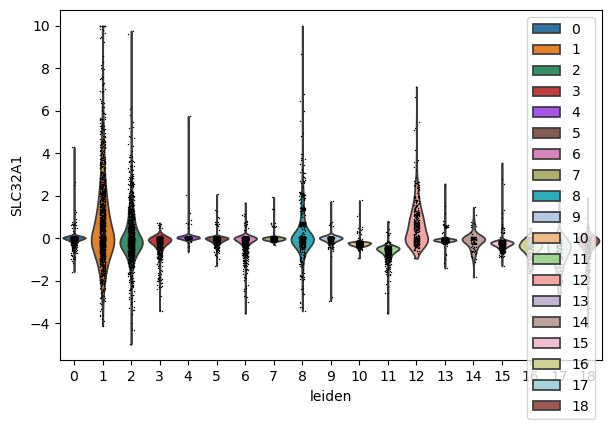

In [5]:
add_markers=["AGRP","SLC17A6","SLC32A1"] #SLC17A6=VGLUT2,SLC32A1=VGAT
for marker in add_markers:
    sc.pl.violin(adata, marker, groupby='leiden')

In [12]:
adata.obs["is_AGRP"] = np.where(adata.obs["AGRP_raw"]>0, 1, 0)
adata.obs["is_AGRP"] =adata.obs["is_AGRP"] .astype("category")

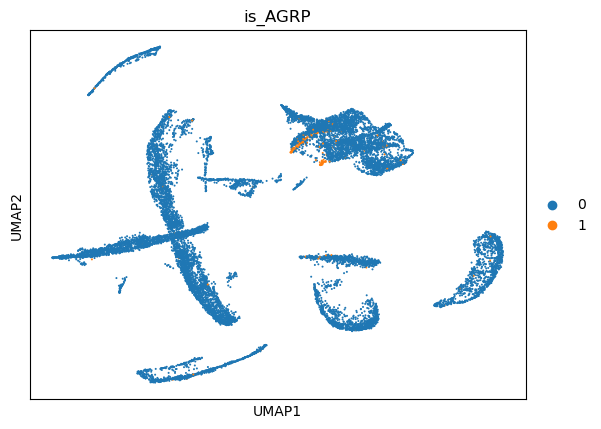

In [13]:
sc.pl.umap(adata, color=["is_AGRP"])

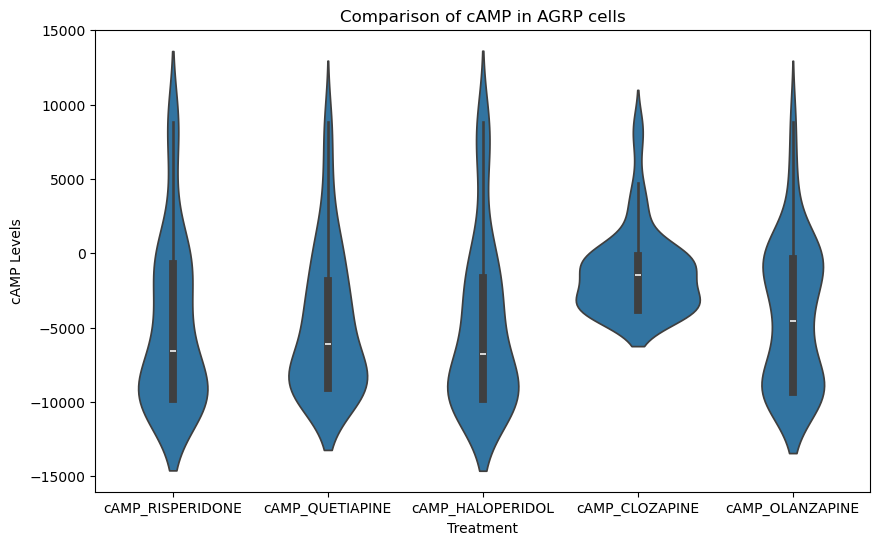

T-test statistic: 3.5901165345597534, p-value: 0.0003815754069255644
Mann-Whitney U test statistic: 24659.0, p-value: 0.30646315291435555


In [16]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats


# is_thirstがTrue（または1）のデータをフィルタリング
AGRP_cells = adata[adata.obs['is_AGRP'] == 1]

# 長い形式（long-form）にデータを整形
long_df = pd.melt(AGRP_cells.obs, id_vars=['is_AGRP'], value_vars=["cAMP_RISPERIDONE","cAMP_QUETIAPINE","cAMP_HALOPERIDOL",'cAMP_CLOZAPINE', 'cAMP_OLANZAPINE'])

# value=0のcellを除外
long_df=long_df[long_df.value!=0]

# ボックスプロットを作成する
plt.figure(figsize=(10, 6))
#sns.boxplot(data=long_df, x='variable', y='value',whis=(25,75),
#            showfliers=True,notch=True,medianprops={"color": "r", "linewidth": 2})
sns.violinplot(data=long_df, x='variable', y='value')
plt.title('Comparison of cAMP in AGRP cells')
plt.xlabel('Treatment')
plt.ylabel('cAMP Levels')
plt.show()

# 統計検定
clozapine_values = AGRP_cells.obs['cAMP_CLOZAPINE']
olanzapine_values = AGRP_cells.obs['cAMP_OLANZAPINE']

# t-test
t_stat, t_pval = stats.ttest_ind(clozapine_values, olanzapine_values, equal_var=False)

# Mann-Whitney U test
u_stat, u_pval = stats.mannwhitneyu(clozapine_values, olanzapine_values)

print(f"T-test statistic: {t_stat}, p-value: {t_pval}")
print(f"Mann-Whitney U test statistic: {u_stat}, p-value: {u_pval}")

In [17]:
# 統計検定
clozapine_values = AGRP_cells.obs['cAMP_CLOZAPINE']
olanzapine_values = AGRP_cells.obs['cAMP_OLANZAPINE']
haloperidol_values = AGRP_cells.obs['cAMP_HALOPERIDOL']

# t-test
t_stat, t_pval = stats.ttest_ind(clozapine_values, haloperidol_values, equal_var=False)

# Mann-Whitney U test
u_stat, u_pval = stats.mannwhitneyu(clozapine_values, haloperidol_values)

print(f"T-test statistic: {t_stat}, p-value: {t_pval}")
print(f"Mann-Whitney U test statistic: {u_stat}, p-value: {u_pval}")

T-test statistic: 4.140842784186146, p-value: 4.516960436921219e-05
Mann-Whitney U test statistic: 25118.0, p-value: 0.14872726042207907
